<a href="https://colab.research.google.com/github/Sang0920/Frequent-Itemset-Mining-w-Big-Data/blob/main/Khai_th%C3%A1c_lu%E1%BA%ADt_k%E1%BA%BF_h%E1%BB%A3p_(Colab_%2B_Clusters%5BLinux%5D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Context
E-commerce has become a new channel to support businesses development. Through e-commerce, businesses can get access and establish a wider market presence by providing cheaper and more efficient distribution channels for their products or services. E-commerce has also changed the way people shop and consume products and services. Many people are turning to their computers or smart devices to order goods, which can easily be delivered to their homes.

**Content**

This is a sales transaction data set of UK-based e-commerce (online retail) for one year. This London-based shop has been selling gifts and homewares for adults and children through the website since 2007. Their customers come from all over the world and usually make direct purchases for themselves. There are also small businesses that buy in bulk and sell to other customers through retail outlet channels.

The data set contains 500K rows and 8 columns. The following is the description of each column.

* TransactionNo (categorical): a six-digit unique number that defines each transaction. The letter “C” in the code indicates a cancellation.
* Date (numeric): the date when each transaction was generated.
* ProductNo (categorical): a five or six-digit unique character used to identify a specific product.
* Product (categorical): product/item name.
* Price (numeric): the price of each product per unit in pound sterling (£).
* Quantity (numeric): the quantity of each product per transaction. Negative values related to cancelled transactions.
* CustomerNo (categorical): a five-digit unique number that defines each customer.
* Country (categorical): name of the country where the customer resides.

There is a small percentage of order cancellation in the data set. Most of these cancellations were due to out-of-stock conditions on some products. Under this situation, customers tend to cancel an order as they want all products delivered all at once.

# PROBLEMS
* How was the sales trend over the months?
* What are the most frequently purchased products?
* How many products does the customer purchase in each transaction?
* What are the most profitable segment customers?
* Based on your findings, what strategy could you recommend to the business to gain more profit?

## Importing libraries

In [ ]:
!pip install pyspark

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import collect_list, expr

# DATA LOADING AND PREPROCESSING

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Big data/Labs/Project/Sales Transaction v.4a.csv")

In [ ]:
df.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom


In [ ]:
df.tail()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
536345,C536548,12/1/2018,22168,Organiser Wood Antique White,18.96,-2,12472.0,Germany
536346,C536548,12/1/2018,21218,Red Spotty Biscuit Tin,14.09,-3,12472.0,Germany
536347,C536548,12/1/2018,20957,Porcelain Hanging Bell Small,11.74,-1,12472.0,Germany
536348,C536548,12/1/2018,22580,Advent Calendar Gingham Sack,16.35,-4,12472.0,Germany
536349,C536548,12/1/2018,22767,Triple Photo Frame Cornice,20.45,-2,12472.0,Germany


In [ ]:
df.shape

(536350, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


#### Let's turn the Date column to DateTime type

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   TransactionNo  536350 non-null  object        
 1   Date           536350 non-null  datetime64[ns]
 2   ProductNo      536350 non-null  object        
 3   ProductName    536350 non-null  object        
 4   Price          536350 non-null  float64       
 5   Quantity       536350 non-null  int64         
 6   CustomerNo     536295 non-null  float64       
 7   Country        536350 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.7+ MB


In [ ]:
df.describe()

,Price,Quantity,CustomerNo
count,536350.000000,536350.000000,536295.000000
mean,12.662182,9.919347,15227.893178
std,8.490450,216.662300,1716.582932
min,5.130000,-80995.000000,12004.000000
25%,10.990000,1.000000,13807.000000
50%,11.940000,3.000000,15152.000000
75%,14.090000,10.000000,16729.000000
max,660.620000,80995.000000,18287.000000


In [ ]:
df.isnull().sum()

TransactionNo     0
Date              0
ProductNo         0
ProductName       0
Price             0
Quantity          0
CustomerNo       55
Country           0
dtype: int64

In [ ]:
df[df['CustomerNo'].isnull()]

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
6511,C581406,2019-12-08,46000M,Polyester Filler Pad 45x45cm,6.19,-240,NaN,United Kingdom
6512,C581406,2019-12-08,46000S,Polyester Filler Pad 40x40cm,6.19,-300,NaN,United Kingdom
90098,C575153,2019-11-08,22947,Wooden Advent Calendar Red,44.25,-1,NaN,United Kingdom
102671,C574288,2019-11-03,22178,Victorian Glass Hanging T-Light,25.37,-1,NaN,United Kingdom
117263,C573180,2019-10-28,23048,Set Of 10 Lanterns Fairy Light Star,14.50,-1,NaN,United Kingdom
163160,C569495,2019-10-04,21843,Red Retrospot Cake Stand,21.47,-1,NaN,United Kingdom
190598,C567518,2019-09-20,22846,Bread Bin Diner Style Red,27.62,-1,NaN,United Kingdom
192284,C567518,2019-09-20,21871,Save The Planet Mug,11.94,-12,NaN,United Kingdom
242406,C563015,2019-08-11,46000M,Polyester Filler Pad 45x45cm,10.25,-160,NaN,United Kingdom
242407,C563015,2019-08-11,46000S,Polyester Filler Pad 40x40cm,10.25,-220,NaN,United Kingdom


**All the null values in CustomerNo have the same country and negative Quantity (except one, whose TransactionNo does not start with the letter 'C' and does not have a negative Quantity)**

#### Let's drop all null and duplicated values

In [ ]:
df.dropna(inplace=True)
df.isnull().sum()

TransactionNo    0
Date             0
ProductNo        0
ProductName      0
Price            0
Quantity         0
CustomerNo       0
Country          0
dtype: int64

In [ ]:
df.duplicated().sum()

5200

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [ ]:
df['CustomerNo'] = df['CustomerNo'].map(int)
df['CustomerNo'] = df['CustomerNo'].map(str)

# ANSWERING OUR QUESTIONS

### Let's quickly remind what we were looking for
1. How was the sales trend over the months?
2. What are the most frequently purchased products?
3. How many products does the customer purchase in each transaction?
4. What are the most profitable segment customers?
5. Based on your findings, what strategy could you recommend to the business to gain more profit?

## 1. How was the sales trend over the months?

In [ ]:
df['Total'] = df['Quantity'] * df['Price']
df['Month_Year'] = pd.to_datetime(df['Date']).dt.to_period('M')
df.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Total,Month_Year
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490,United Kingdom,257.64,2019-12
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069,United Kingdom,383.40,2019-12
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069,United Kingdom,138.36,2019-12
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069,United Kingdom,127.80,2019-12
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069,United Kingdom,71.64,2019-12


In [ ]:
total_month = df.groupby(['Month_Year'], as_index=False)['Total'].sum()
total_month.columns = ['Date', 'Total']
total_month.head()

,Date,Total
0,2018-12,4217281.53
1,2019-01,3638948.12
2,2019-02,3292324.69
3,2019-03,4340035.60
4,2019-04,3406002.17


In [ ]:
import plotly.express as px

In [ ]:
# total_month.iplot(x = 'Date', y = 'Total', title = 'Sales Trend Over the Months',
#                   yTitle = 'Total Money', xTitle = 'Month', mode="lines+markers", size = 6)
total_month.Date = total_month.Date.astype('str')
fig = px.line(total_month, x='Date', y='Total', title='Sales Trend Over the Months',
              labels={'Total': 'Total Money', 'Date': 'Month'})
fig.show()

In [ ]:
df_no_return = df[df['Quantity'] > 0]
number_of_sales = df_no_return.groupby(by='Month_Year', as_index=False)['Total'].count()
number_of_sales.columns = ['Date', 'Sum of sales']
number_of_sales.Date = number_of_sales.Date.astype('str')
# number_of_sales.iplot(x = 'Date', y = 'Sum of sales', title = 'Number of Sales Each Month',
#                   yTitle = 'Number of Sales', xTitle = 'Month', mode="lines+markers", size = 6)
fig = px.line(number_of_sales, x='Date', y='Sum of sales', \
              title='Number of Sales Each Month', \
              labels={'Sum of sales': 'Number of Sales', 'Date': 'Month'}, \
              line_shape="linear", render_mode="svg")
fig.show()

In [ ]:
df.sort_values('Date', ascending = False).head(5)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Total,Month_Year
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490,United Kingdom,257.64,2019-12
1076,581498,2019-12-09,21930,Jumbo Storage Bag Skulls,6.19,2,14498,United Kingdom,12.38,2019-12
1086,581498,2019-12-09,22041,"Record Frame 7"" Single Size",6.19,2,14498,United Kingdom,12.38,2019-12
1085,581498,2019-12-09,21989,Pack Of 20 Skull Paper Napkins,6.19,1,14498,United Kingdom,6.19,2019-12
1084,581498,2019-12-09,21987,Pack Of 6 Skull Paper Cups,6.19,2,14498,United Kingdom,12.38,2019-12


### Answer

We can see that from December 2018 to August 2019 there is no big change in total income or number of sales. But things are getting different from that point, maybe due to Christmas, we can see a rising trend on our charts. According to them, December 2019 was the worst month in sales and income, however, we can observe, that it is due to a lack of data. Our dataset is only up to 9th December, whereas all other months have full data. There is only info of 9 days in December 2019, but we already have more than half the number of sales than in December 2018 and almost half of income. So we can guess that December 2019 would have been richer in sales and income than a year ago.

-----------------------------



## 2. What are the most frequently purchased products?

In [ ]:
popular_products = df.groupby(by='ProductName', as_index = False)['Quantity'].sum()
# popular_products.sort_values('Quantity', ascending = False).head(10).iplot(kind = 'bar', x = 'ProductName', y = 'Quantity', title = '10 Most Frequently Purchased Products')
top_products = popular_products.sort_values('Quantity', ascending=False).head(10)
fig = px.bar(top_products, x='ProductName', y='Quantity',
             title='10 Most Frequently Purchased Products',
             labels={'Quantity': 'Total Quantity', 'ProductName': 'Product'},
             color='Quantity',
             color_continuous_scale=px.colors.sequential.Viridis)
fig.show()




## 3. How many products does the customer purchase in each transaction?

Let's see the top 10 quantity amount

In [ ]:
import plotly.graph_objects as go

In [ ]:
top_quantity = df.sort_values('Quantity', ascending = False)[['Quantity', 'TransactionNo']].head(10).reset_index(drop = True)
# top_quantity.iplot(kind = 'bar', title = 'Top 10 Quantity', x = 'TransactionNo', xTitle = 'Transaction Number')

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=top_quantity['TransactionNo'],
    y=top_quantity['Quantity'],
    text=top_quantity['Quantity'],
    textposition='auto',
    marker=dict(color='skyblue'),
))

fig.update_layout(
    title='Top 10 Quantity',
    xaxis=dict(title='Transaction Number'),
    yaxis=dict(title='Quantity'),
)

fig.show()




#### I will calculate the mean of positive quantities, that will be my answer to question

In [ ]:
round(df_no_return['Quantity'].mean())

11

### Answer

The average number of products bought per transaction is **11**

--------------------------



## 4. What are the most profitable segment customers?

#### Let me check which countries are the most and least profitable

In [ ]:
most_profitable_countries = df.groupby(by='Country', as_index = False)['Total'].sum().sort_values('Total', ascending = False).head(10)
least_profitable_countries = df.groupby(by='Country', as_index = False)['Total'].sum().sort_values('Total').head(10)

In [ ]:
fig_most_profitable = px.bar(
    most_profitable_countries,
    x='Country',
    y='Total',
    title='Most Profitable Countries',
    labels={'Total': 'Income'},
    color='Total',
)

fig_least_profitable = px.bar(
    least_profitable_countries,
    x='Country',
    y='Total',
    title='Least Profitable Countries',
    labels={'Total': 'Income'},
    color='Total',
)

fig_most_profitable.show()
fig_least_profitable.show()

#### The most popular products in UK

In [ ]:
popular_UK = df_no_return[df_no_return['Country'] == 'United Kingdom']
# popular_UK.groupby(by='ProductName', as_index = False)['Total'].count().head().sort_values('Total', ascending = False).iplot(kind = 'pie', labels = 'ProductName', values = 'Total', hole = .4, title = 'Most Popular Products in UK')
# popular_UK.groupby(by='ProductName', as_index = False)['Total'].sum().head().sort_values('Total', ascending = False).iplot(kind = 'pie', labels = 'ProductName', values = 'Total', hole = .4, title = 'Top High-Income Products in the UK')
fig_most_popular_uk = px.pie(
    popular_UK.groupby(by='ProductName', as_index=False)['Total'].count().head(),
    names='ProductName',
    values='Total',
    title='Most Popular Products in UK',
    hole=0.4,
)

fig_top_high_income_uk = px.pie(
    popular_UK.groupby(by='ProductName', as_index=False)['Total'].sum().head(),
    names='ProductName',
    values='Total',
    title='Top High-Income Products in the UK',
    hole=0.4,
)

fig_most_popular_uk.show()
fig_top_high_income_uk.show()

#### Let's see now which products are providing the highest income worlwide

In [ ]:
most_profitable_products = df.groupby(by='ProductName', as_index = False)['Total'].sum().sort_values('Total', ascending = False).head(10)
# most_profitable_products.iplot(kind = 'bar', x =  'ProductName', title = 'Top 10 High Income Products Worldwide', yTitle = 'Income', colors = '#FF8552')
fig_most_profitable = px.bar(
    most_profitable_products,
    x='ProductName',
    y='Total',
    title='Top 10 High Income Products Worldwide',
    labels={'Total': 'Income'},
    color_discrete_sequence=['#FF8552'],
)

fig_most_profitable.show()

In [ ]:
top_customers = df.groupby(by='CustomerNo', as_index=False)['Total'].sum().sort_values('Total', ascending=False).head(10)

fig_top_customers = px.bar(
    top_customers,
    x='CustomerNo',
    y='Total',
    title='Top 10 Most Profitable Customers',
    labels={'Total': 'Total Income', 'CustomerNo': 'Customer Number'},
    color_discrete_sequence=['#CC3363'],  # Set your desired color
)

fig_top_customers.show()

### Answer

Most profitable segment customers are customers from countries included in 'Most Profitable Countries' (especially UK)

----------------------

## 5. Based on your findings, what strategy could you recommend to the business to gain more profit?

#### We need a little more research

In [ ]:
df_negative_quantity = df[df['Quantity'] < 0]
df_negative_quantity['Quantity'] = abs(df_negative_quantity['Quantity'])
# df_negative_quantity.groupby(by = 'ProductName', as_index = False)['Quantity'].sum().sort_values('Quantity', ascending = False).head(10).iplot(kind = 'bar', x = 'ProductName', y = 'Quantity',
#                                                                                                                                               title = 'Top Canceled Products', colors = '#FF5A5F')
top_canceled_products = df_negative_quantity.groupby(by='ProductName', as_index=False)['Quantity'].sum().sort_values('Quantity', ascending=False).head(10)

# Create a bar chart
fig_top_canceled_products = px.bar(
    top_canceled_products,
    x='ProductName',
    y='Quantity',
    title='Top Canceled Products',
    labels={'Quantity': 'Total Canceled Quantity', 'ProductName': 'Product Name'},
    color_discrete_sequence=['#FF5A5F'],  # Set your desired color
)
fig_top_canceled_products.show()

<ipython-input-34-030faaa8c252>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_negative_quantity = df[df['Quantity'] < 0]

# Take the absolute values of Quantity
df_negative_quantity['Quantity'] = abs(df_negative_quantity['Quantity'])

# Group by Country and sum the Quantity
top_canceled_countries = df_negative_quantity.groupby(by='Country', as_index=False)['Quantity'].sum().sort_values('Quantity', ascending=False).head(10)

fig_top_canceled_countries = px.bar(
    top_canceled_countries,
    x='Country',
    y='Quantity',
    title='Countries With Most Canceled Transactions',
    labels={'Quantity': 'Total Canceled Quantity', 'Country': 'Country'},
    color_discrete_sequence=['#A6808C'],  # Set your desired color
)
fig_top_canceled_countries.show()

<ipython-input-35-f358162792f6>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Answer

1. The company needs to improve shipping or advertising more to other countries than the UK.
2. I would suggest checking on the first two products on 'Top Canceled Products'. The company lost 150k orders because of these two products' order cancelation..
3. Advertising best-selling products in other countries than the UK.
4. Increasing the ads budget a couple months before Christmas may be a good idea.

----------------------------

# Finding frequent itemsets using Spark

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import collect_list, expr
import pandas as pd

spark = SparkSession.builder.appName("FIS").getOrCreate()

df = pd.read_csv('/content/drive/MyDrive/Big data/Labs/Project/Sales Transaction v.4a.csv')
df = df[df['Country'] == 'France']
df['Date'] = pd.to_datetime(df['Date'])
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df['CustomerNo'] = df['CustomerNo'].astype('int')
df['CustomerNo'] = df['CustomerNo'].astype('str')
df = df[~df['TransactionNo'].str.startswith("C")]
df = df.drop_duplicates(subset=['TransactionNo', 'ProductNo'])
df = spark.createDataFrame(df)
transaction_data = df.groupBy("TransactionNo").agg(collect_list("ProductNo").alias("items"))
transaction_data.show(20)

fpGrowth = FPGrowth(itemsCol="items", minSupport=0.01, minConfidence=0.9)
model = fpGrowth.fit(transaction_data)

print("Frequent Itemsets:")
model.freqItemsets.show(10, truncate=False)

print("Association Rules:")
model.associationRules.show()

spark.stop()

+-------------+--------------------+
|TransactionNo|               items|
+-------------+--------------------+
|       536370|[22728, 22727, 22...|
|       536852|[22549, 22544, 22...|
|       536974|[15056P, 20679, 2...|
|       537065|[84963A, 22837, 2...|
|       537463|[22961, 21224, 22...|
|       537468|[22114, 21485, 22...|
|       537640|[21080, 21098, 21...|
|       537693|[22710, 22052, 22...|
|       537897|[22601, 22661, 22...|
|       537967|      [22667, 21843]|
|       538008|[22331, 22907, 22...|
|       538093|[22736, 22738, 20...|
|       538196|[84879, 10002, 22...|
|       539050|[21069, 21328, 22...|
|       539113|             [22662]|
|       539272|[22273, 21506, 22...|
|       539407|[22264, 22492, 22...|
|       539435|[21731, 22326, 20...|
|       539551|[21731, 22466, 84...|
|       539607|[84997D, 22895, 2...|
+-------------+--------------------+
only showing top 20 rows

Frequent Itemsets:
+-----------------------------------+----+
|items                  

# Thực nghiệm lại trong cluster

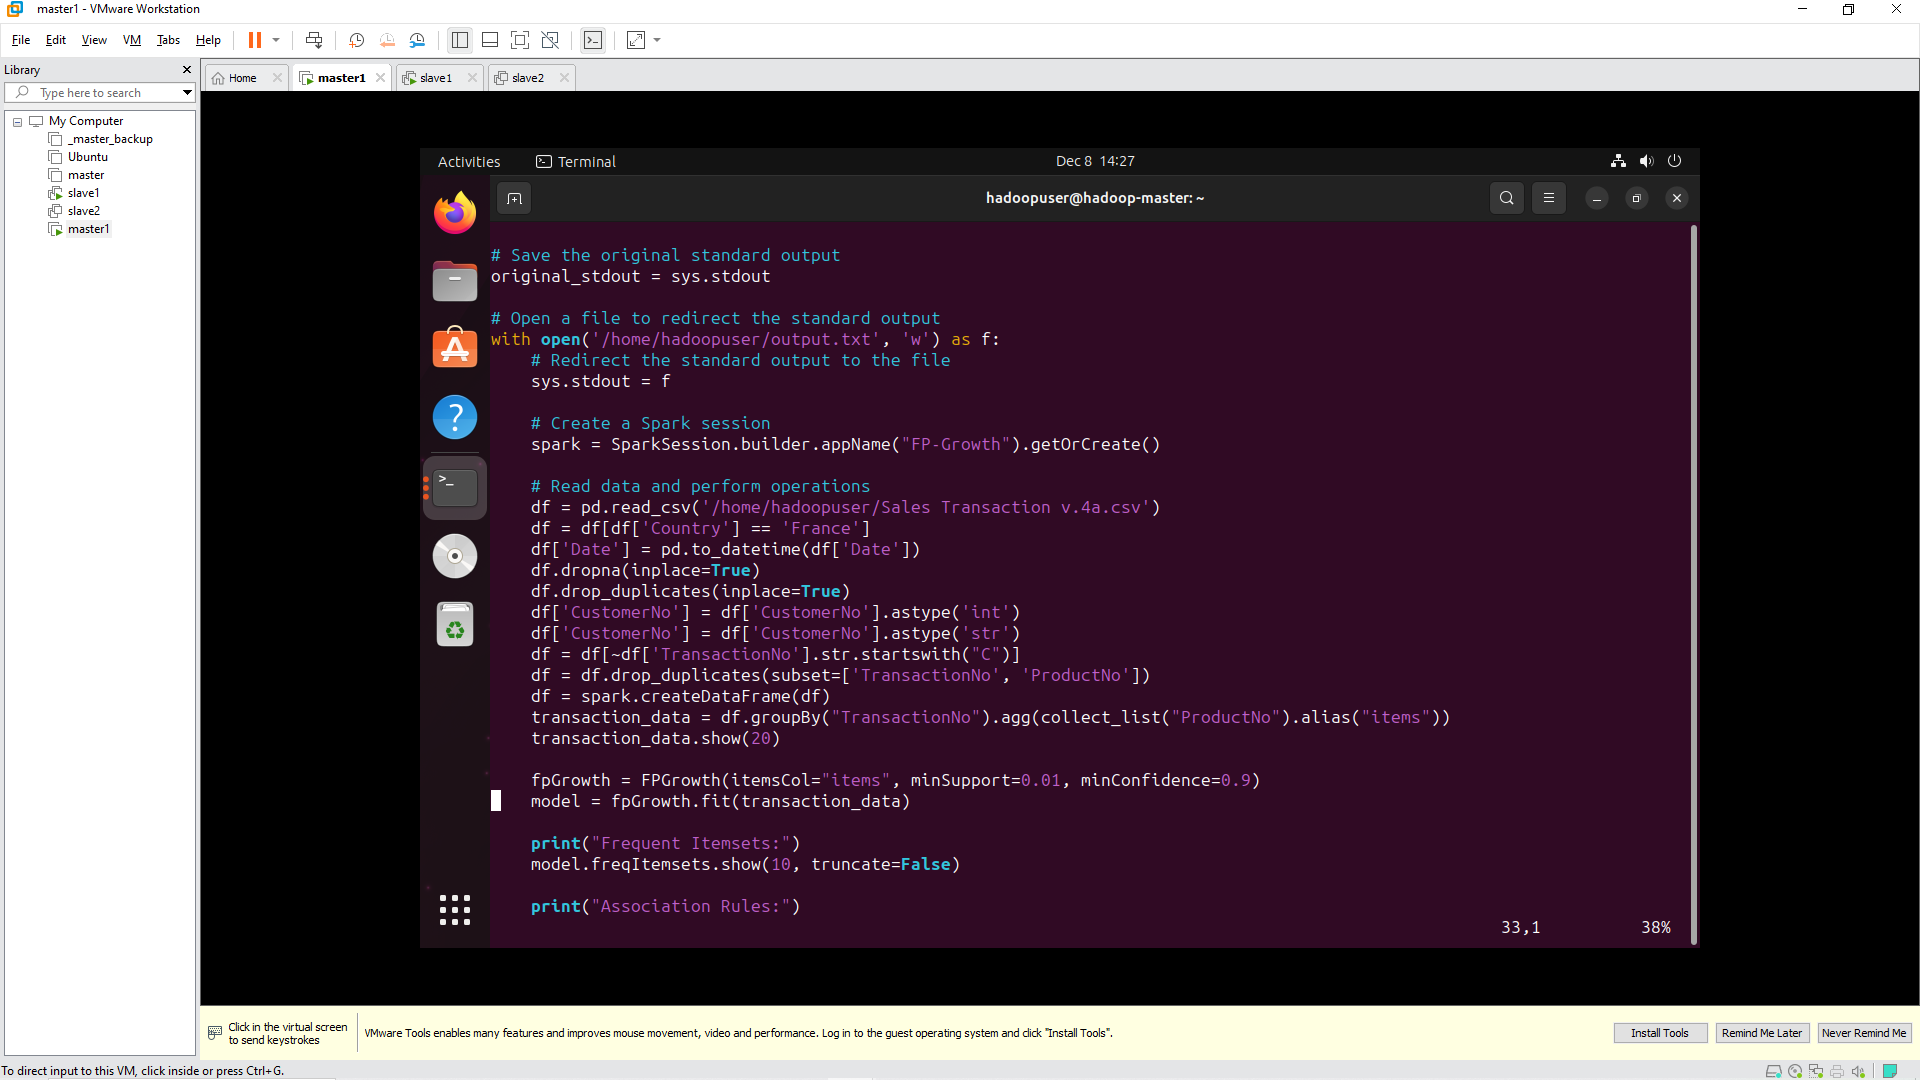

Lưu file thành fpgrowth.py và thực hiện các bước sau.

Chạy đoạn code trên trên cluster gồm các máy master, slave1 và slave2.

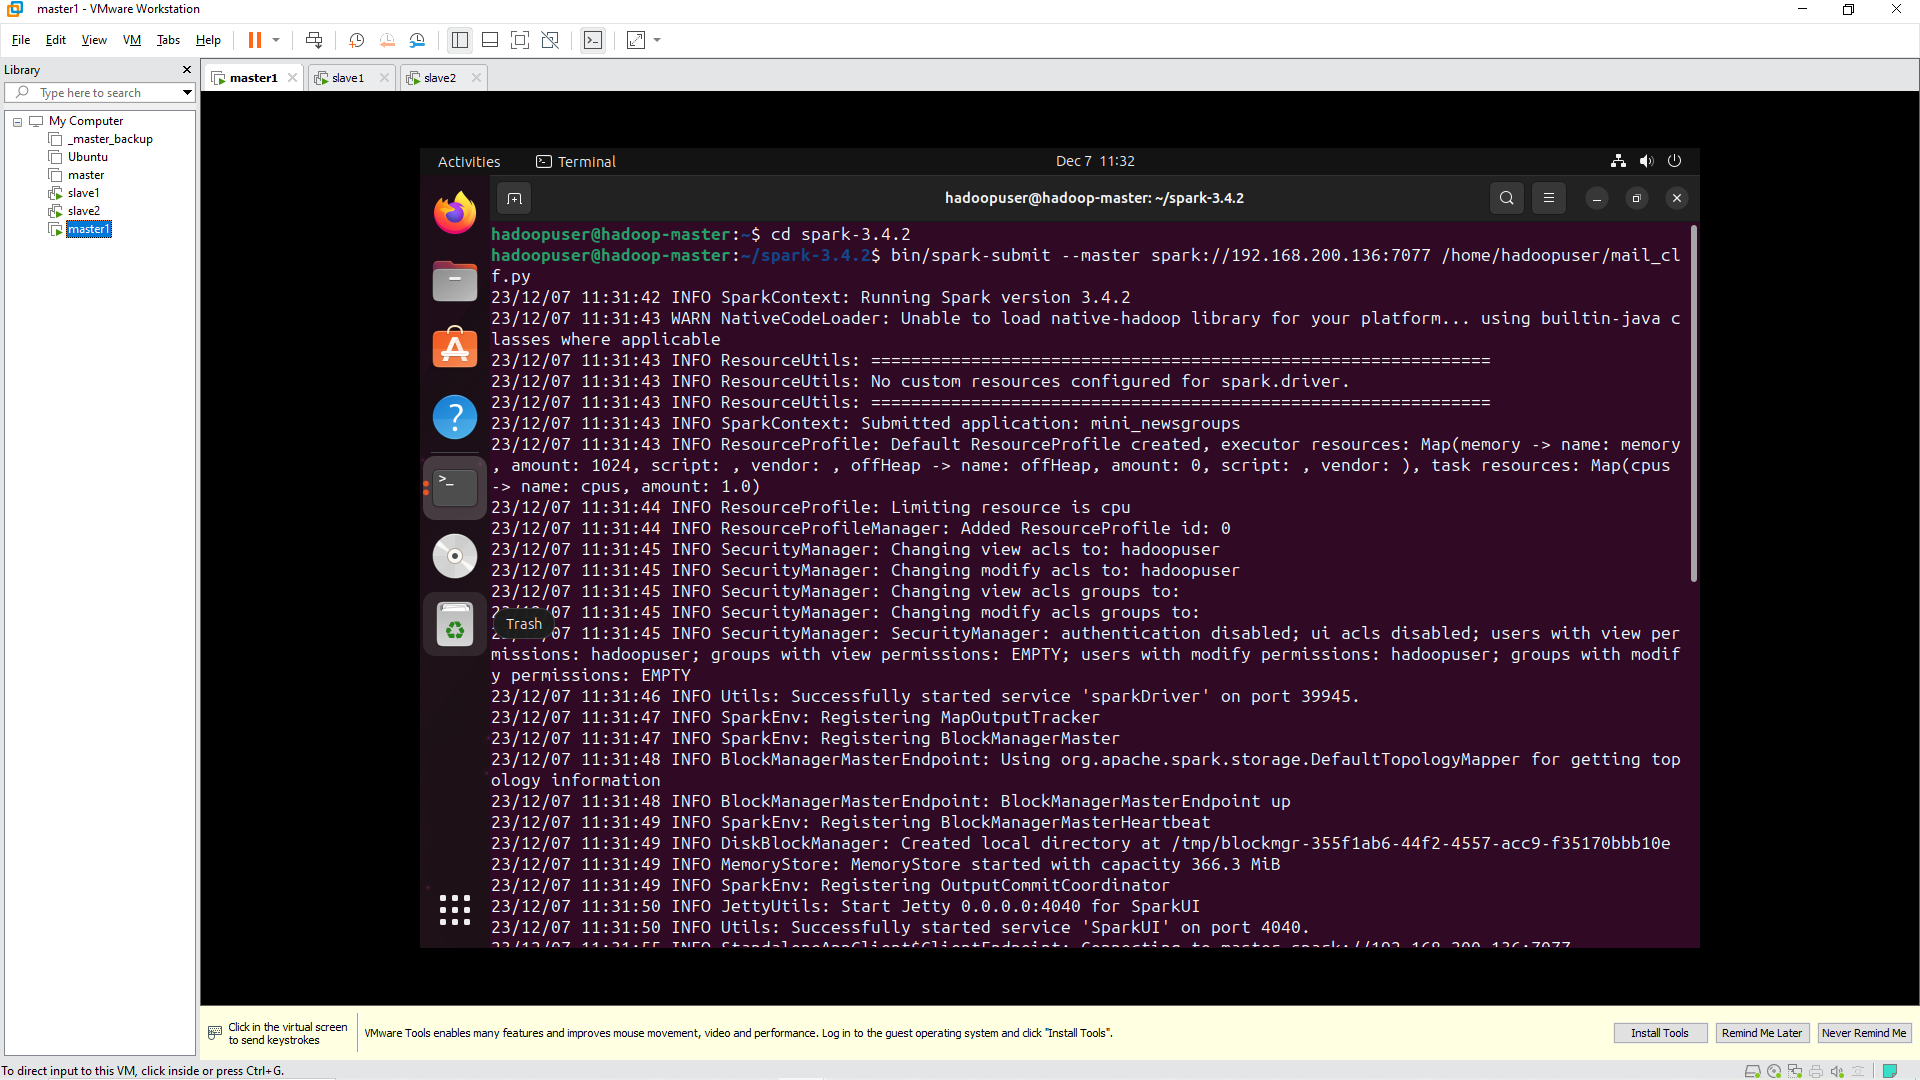

Kết quả được lưu vào file output.txt


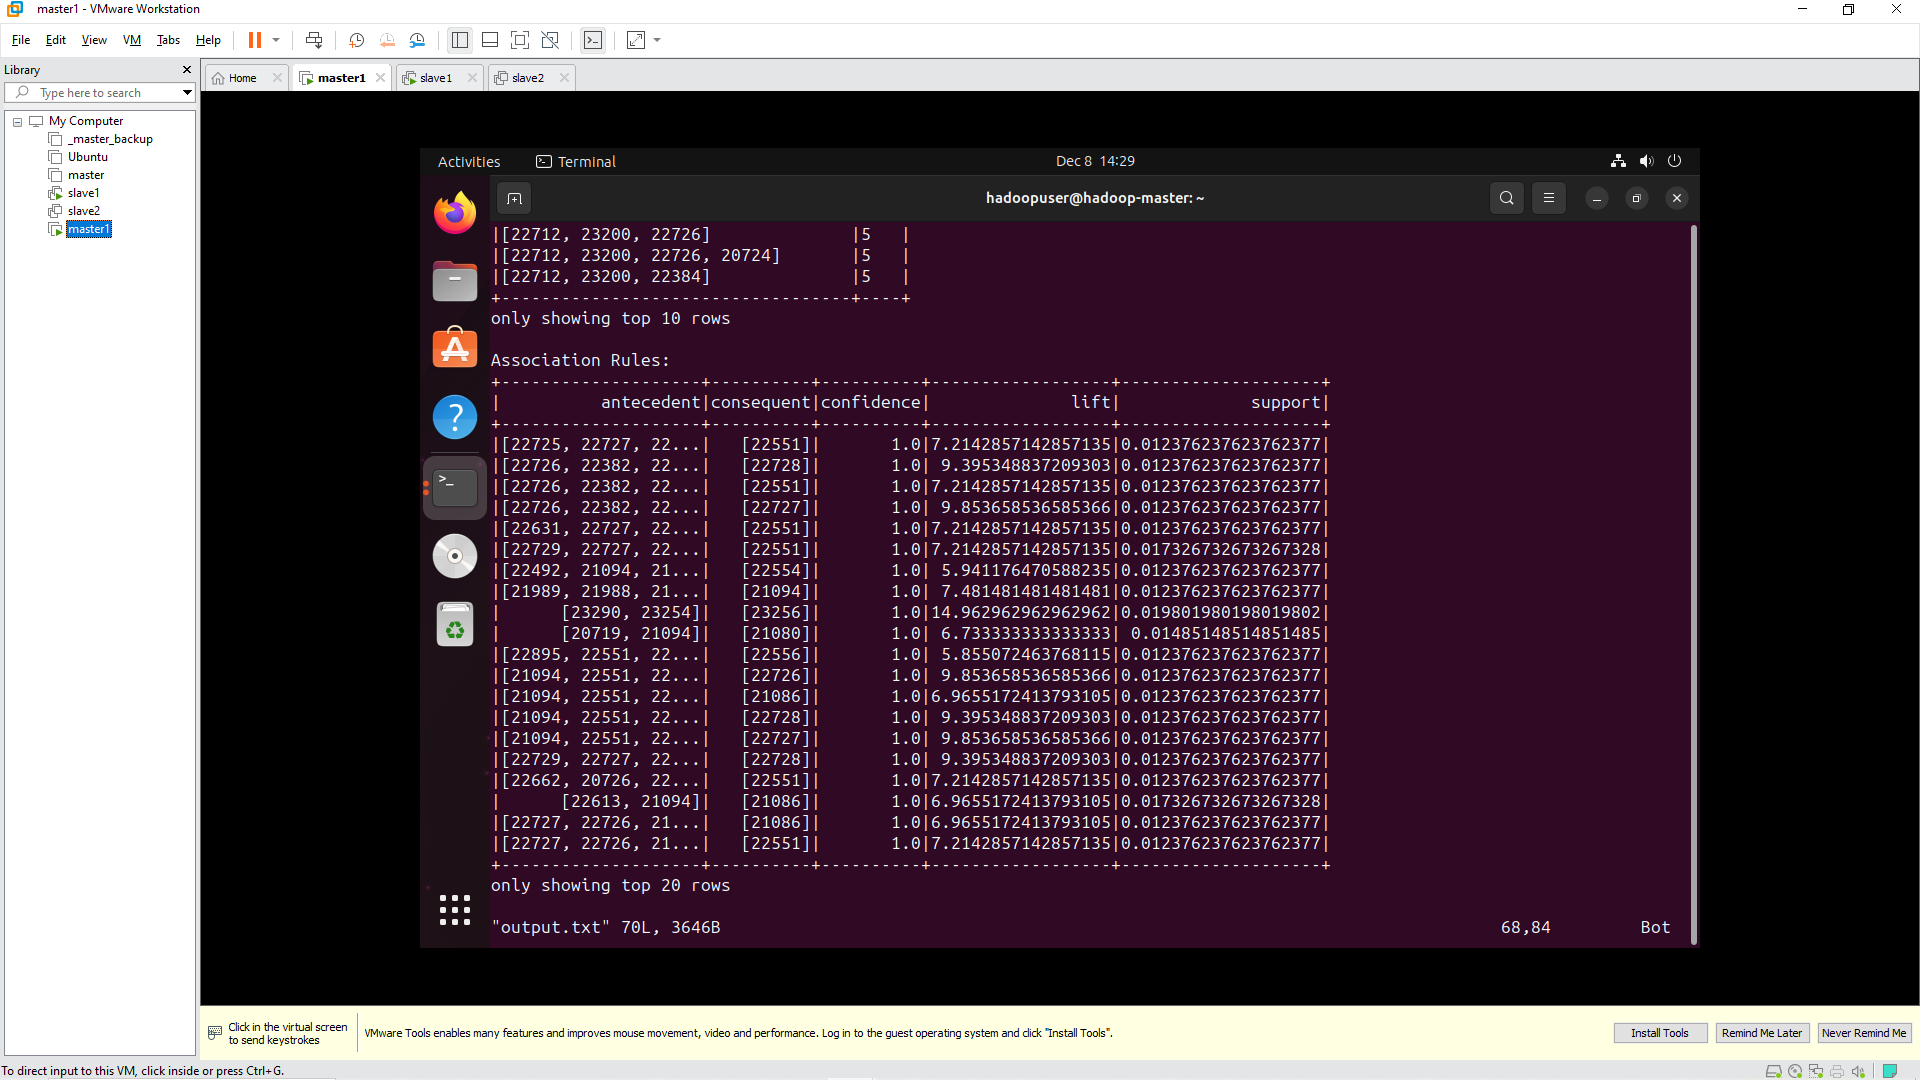